<!---
The MIT License (MIT)

Copyright (c) 2017 Sean UN Wood

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
--->

# Online Speech Enhancement with GCC-NMF
## iPython Notebook Demo

#### Sean UN Wood, August 2017

This iPython Notebook is a demonstration of the algorithm presented in:

 - Sean UN Wood and Jean Rouat, [*Real-time Speech Enhancement with GCC-NMF*](https://www.researchgate.net/publication/318511757_Real-time_Speech_Enhancement_with_GCC-NMF), **Interspeech 2017**  

building on previous work:
 - Sean UN Wood, Jean Rouat, Stéphane Dupon, Gueorgui Pironkov, [*Speech Separation and Enhancement with GCC-NMF*](https://www.gel.usherbrooke.ca/rouat/publications/IEEE_ACMTrGCCNMFWoodRouat2017.pdf), **IEEE TASLP 2017**, DOI: [10.1109/TASLP.2017.2656805](https://doi.org/10.1109/TASLP.2017.2656805)
 - Sean UN Wood and Jean Rouat, [*Speech Separation with GCC-NMF*](http://www.isca-speech.org/archive/Interspeech_2016/pdfs/1449.PDF), **Interspeech 2016**, DOI: [10.21437/Interspeech.2016-1449](http://dx.doi.org/10.21437/Interspeech.2016-1449)

## Abstract

In this demo, we present the online GCC-NMF variant for blind speech enhancement. We enhance the noisy speech signal found at *data/dev_Sq1_Co_A_mix.wav*, taken from the SiSEC 2016 [Two-channel Mixtures of Speech and Real-world Background Noise](https://sisec.inria.fr/sisec-2015/2015-two-channel-mixtures-of-speech-and-real-world-background-noise/) "dev" dataset, and save the result to the *data* directory. Dictionary pre-learning is performed in an unsupervised fashion using a small subset of isolated speech and noise frames from the [CHiME 2016 dataset](http://spandh.dcs.shef.ac.uk/chime_challenge/) that we have preprocessed and stored locally at *data/chimeTrainSet.npy*.

Performing speech enhancement with GCC-NMF in real-time requires three modifications to the offline approach presented previously:
 - Dictionary pre-learning: The NMF dictionary is pre-learned from a different dataset than used at test time containing isolated speech and noise signals.
 - Online coefficient inference: The NMF dictionary coefficients are inferred online on a frame-by-frame basis.
 - Online target tracking: The source is tracked online using an accumulated GCC-PHAT localization approach.

## Notebook Overview

1. Preliminary setup
2. Load input mixture signal
3. NMF Dictionary Pre-learning
4. Perform speech enhancement frame-by-frame:
  - Compute FFT of current frame
  2. Perform source localization with accumulated GCC-PHAT
  3. Generate GCC-NMF coefficient mask
  4. Construct wiener filter, and filter current frame
  5. Reconstruct Target signal estimate of current frame via inverse FFT
  6. Perform overlap add to generate output samples

# 1. Preliminary setup
#### Python imports

In [1]:
from gccNMF.gccNMFFunctions import *
from gccNMF.gccNMFPlotting import *
from gccNMF.wavfile import wavwrite

from numpy import *
from numpy.fft import rfft, irfft
from matplotlib.pylab import cm

from IPython import display

%matplotlib inline

#### Parameter definitions

In [2]:
# Preprocessing params
windowSize = 1024
fftSize = windowSize
hopSize = 128
window = hanning(windowSize)

# TDOA params
numTDOAs = 128
targetTDOAEpsilonPercent = 0.05 # controls the TDOA width for GCC-NMF mask generation
targetTDOAEpsilon = targetTDOAEpsilonPercent * numTDOAs

# NMF params
trainingDataFileName = '../data/chimeTrainSet.npy'
dictionarySize = 128
numPreLearningIterations = 100
numInferenceIterations = 0
sparsityAlpha = 0
epsilon = 1e-16
seedValue = 0

# Input params    
mixtureFileNamePrefix = '../data/dev_Sq1_Co_A'
microphoneSeparationInMetres = 0.086

# 2. Input mixture signal

#### Load noisy speech signal from the wav file

In [3]:
mixtureFileName = getMixtureFileName(mixtureFileNamePrefix)
stereoSamples, sampleRate = loadMixtureSignal(mixtureFileName)

numChannels, numSamples = stereoSamples.shape
durationInSeconds = numSamples / float(sampleRate)

display.display( display.Audio(mixtureFileName) )

#### Plot noisy speech signal

Input mixture signal:
	sampleRate: 16000 samples/sec
	numChannels: 2
	numSamples: 160000
	dtype: float32
	duration: 10.00 seconds


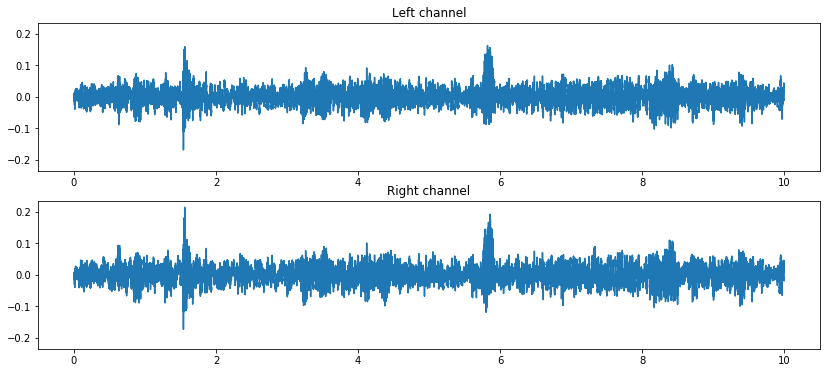

In [4]:
describeMixtureSignal(stereoSamples, sampleRate)

figure(figsize=(14, 6))
plotMixtureSignal(stereoSamples, sampleRate)

# 3. NMF Dictionary Pre-learning

Pre-learn the NMF dictionary from a small subset of the [CHiME dataset](http://spandh.dcs.shef.ac.uk/chime_challenge/). A total of 1024 FFT frames are loaded divided equally between isolated speech and noise signals.

#### Load CHiME training data

In [5]:
trainV = load(trainingDataFileName)
numFrequencies, numTrainFrames = trainV.shape
frequenciesInHz = getFrequenciesInHz(sampleRate, numFrequencies)
frequenciesInkHz = frequenciesInHz / 1000.0

#### Plot CHiME training data

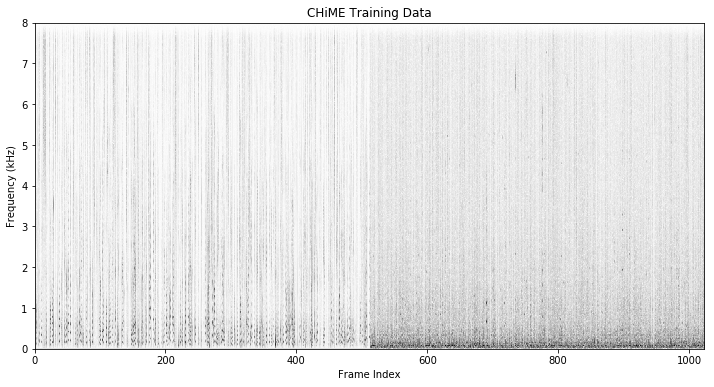

In [6]:
figure(figsize=(12, 6))
imshow((trainV / max(trainV)) ** (1/3.0),
        extent=[0, trainV.shape[1]-1, frequenciesInkHz[0], frequenciesInkHz[-1]],
        cmap=cm.binary)
title('CHiME Training Data')
ylabel('Frequency (kHz)')
xlabel('Frame Index')
show()

#### Learn NMF dictionary

In [7]:
W, H = performKLNMF(trainV, dictionarySize, numPreLearningIterations,
                    sparsityAlpha, epsilon, seedValue)

#### Plot NMF dictionary

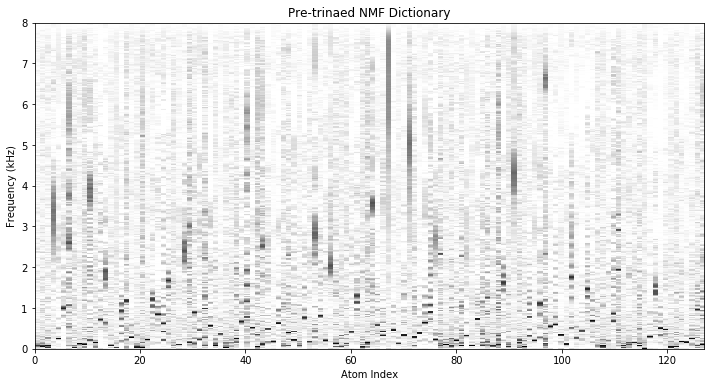

In [8]:
figure(figsize=(12, 6))
imshow((W / max(W)) ** (1/3.0),
        extent=[0, W.shape[1]-1, frequenciesInkHz[0], frequenciesInkHz[-1]],
        cmap=cm.binary)
title('Pre-trinaed NMF Dictionary')
ylabel('Frequency (kHz)')
xlabel('Atom Index')
show()

# 4. Online Speech Enhancement

#### Setup variables to save speech enhancement results:

In [9]:
numFrames = (numSamples-windowSize) // hopSize
maxSample = numFrames * hopSize + windowSize

tdoasInSeconds = getTDOAsInSeconds(microphoneSeparationInMetres, numTDOAs)
expJOmegaTau = exp( outer(frequenciesInHz, -(2j * pi) * tdoasInSeconds) )

targetEstimateSamplesOLA = zeros_like(stereoSamples)
gccPHATAccumulatedMax = zeros(numTDOAs)
gccPHATAccumulatedMax[:] = -inf
atomMask = zeros(dictionarySize)
targetTDOAs = zeros(numFrames)
targetTDOAs[:] = nan

angularSpectrogram = zeros( (numTDOAs, numFrames) )
atomMasks = zeros( (dictionarySize, numFrames) )
wienerFilters = zeros( (2, numFrequencies, numFrames) )
inputSpectrogram = zeros( (2, numFrequencies, numFrames), 'complex64')
outputSpectrogram = zeros( (2, numFrequencies, numFrames), 'complex64')

#### For each STFT frame:
  1. Compute FFT
  2. Localize target with accumulated GCC-PHAT localization
  3. Compute GCC-NMF atom mask
  4. Construct Wiener-like filter, and filter input
  5. Reconstruct time domain samples
  6. Overlap-add to output samples

In [10]:
for frameIndex in range(numFrames):
    # Compute FFT
    frameStart = frameIndex * hopSize
    frameEnd = frameStart + windowSize
    stereoSTFTFrame = rfft( stereoSamples[:, frameStart:frameEnd] * window )
    inputSpectrogram[..., frameIndex] = stereoSTFTFrame
    
    # localize target with accumulated GCC-PHAT
    coherenceV = stereoSTFTFrame[0] * stereoSTFTFrame[1].conj() / abs(stereoSTFTFrame[0]) / abs(stereoSTFTFrame[1])
    gccPHAT = dot(coherenceV, expJOmegaTau).real
    gccPHATAccumulatedMax = max( array( [gccPHAT, gccPHATAccumulatedMax] ), axis=0 )
    targetTDOAEstimate = argmax(gccPHATAccumulatedMax)
    targetTDOAs[frameIndex] = targetTDOAEstimate
    angularSpectrogram[:, frameIndex] = gccPHAT
    
    # compute GCC-NMF atom mask
    gccNMF = dot( (coherenceV[:, newaxis] * expJOmegaTau).real.T, W )
    gccNMFTDOAEstimates = argmax(gccNMF, axis=0)
    atomMask[:] = 0
    atomMask[ abs(gccNMFTDOAEstimates - targetTDOAEstimate) < targetTDOAEpsilon ] = 1
    atomMasks[:, frameIndex] = atomMask
        
    # construct wiener filter
    if numInferenceIterations == 0:
        wienerFilter = sum(atomMask * W, axis=1) / sum(W, axis=1)
        wienerFilters[:, :, frameIndex] = wienerFilter
    else:
        stereoH = inferCoefficientsKLNMF( abs(stereoSTFTFrame).T, W, numInferenceIterations,
                                          sparsityAlpha, epsilon, seedValue)
        recV = dot(W, stereoH)
        sourceEstimate = dot(W, stereoH * atomMask[:, newaxis])
        wienerFilter = (sourceEstimate / recV).T
        wienerFilters[:, :, frameIndex] = wienerFilter
    
    filterdSTFTFrame = wienerFilter * stereoSTFTFrame
    outputSpectrogram[..., frameIndex] = filterdSTFTFrame
    
    # reconstruct time domain samples
    recStereoSTFTFrame = irfft(filterdSTFTFrame)

    # overlap-add to output samples
    targetEstimateSamplesOLA[:, frameStart:frameEnd] += recStereoSTFTFrame

#### Plot online localization results:

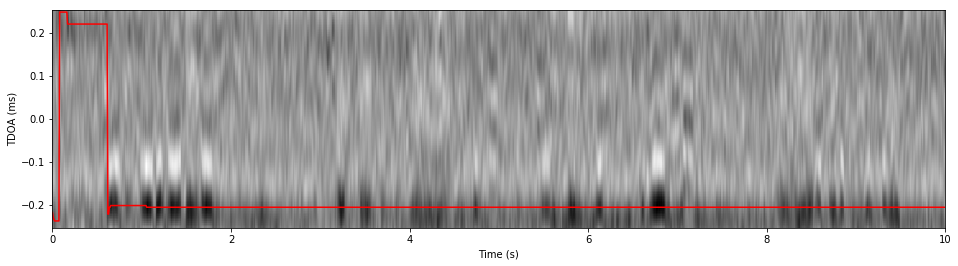

In [11]:
figure(figsize=(16, 4))
imshow(angularSpectrogram,
       extent=[0, durationInSeconds, tdoasInSeconds[0]*1000.0, tdoasInSeconds[-1]*1000.0], cmap=cm.binary)
targetTDOAsInMilliSeconds = take(tdoasInSeconds, targetTDOAs.astype('int32')) * 1000.0
plot( linspace(0, durationInSeconds, len(targetTDOAs)), targetTDOAsInMilliSeconds, 'r')
ylabel('TDOA (ms)')
xlabel('Time (s)')
show()

#### Plot NMF coefficient mask:

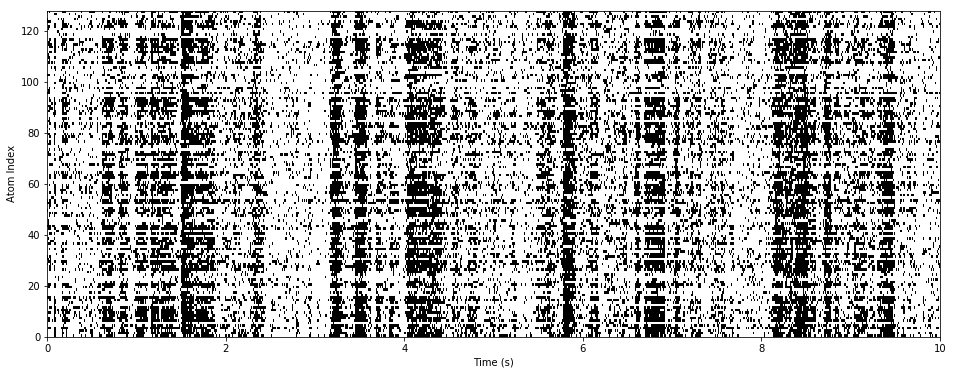

In [12]:
figure(figsize=(16, 6))
imshow(atomMasks, cmap=cm.binary,
       extent=[0, durationInSeconds, 0, dictionarySize])
ylabel('Atom Index')
xlabel('Time (s)')
show()

#### Plot Wiener filters:

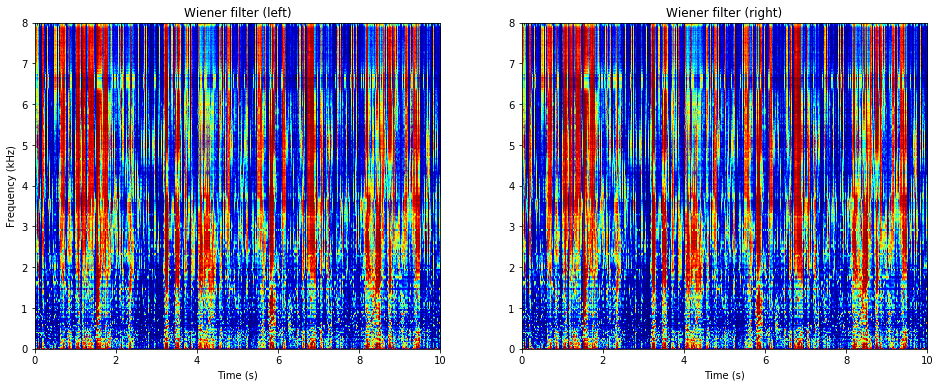

In [13]:
figure(figsize=(16, 6))
ax = subplot(121)
imshow(wienerFilters[0], cmap=cm.jet,
       extent=[0, durationInSeconds, frequenciesInkHz[0], frequenciesInkHz[-1]])
ylabel('Frequency (kHz)')
xlabel('Time (s)')
title('Wiener filter (left)')

ax = subplot(122)
imshow(wienerFilters[1], cmap=cm.jet,
       extent=[0, durationInSeconds, frequenciesInkHz[0], frequenciesInkHz[-1]])
xlabel('Time (s)')
title('Wiener filter (right)')

show()

#### Plot input / output spectrograms:

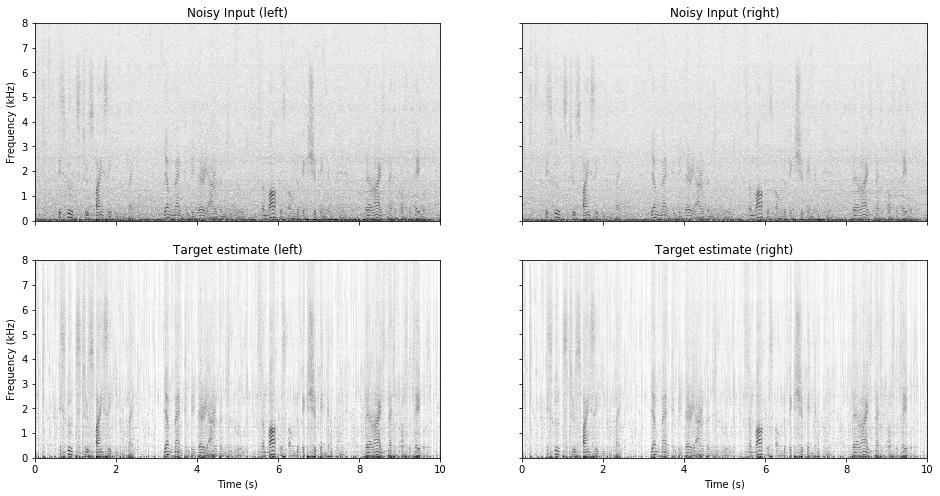

In [14]:
figure(figsize=(16, 8))

ax = subplot(221)
imshow( abs(inputSpectrogram[0]) ** (1/3.0), cmap=cm.binary,
        extent=[0, durationInSeconds, frequenciesInkHz[0], frequenciesInkHz[-1]] )
ax.set_xticklabels([])
ylabel('Frequency (kHz)')
title('Noisy Input (left)')

ax = subplot(222)
imshow( abs(inputSpectrogram[1]) ** (1/3.0), cmap=cm.binary,
        extent=[0, durationInSeconds, frequenciesInkHz[0], frequenciesInkHz[-1]] )
ax.set_xticklabels([])
ax.set_yticklabels([])
title('Noisy Input (right)')

ax = subplot(223)
imshow( abs(outputSpectrogram[0]) ** (1/3.0), cmap=cm.binary,
        extent=[0, durationInSeconds, frequenciesInkHz[0], frequenciesInkHz[-1]] )
ylabel('Frequency (kHz)')
xlabel('Time (s)')
title('Target estimate (left)')

ax = subplot(224)
imshow( abs(outputSpectrogram[1]) ** (1/3.0), cmap=cm.binary,
        extent=[0, durationInSeconds, frequenciesInkHz[0], frequenciesInkHz[-1]] )
ax.set_yticklabels([])
xlabel('Time (s)')
title('Target estimate (right)')

show()

#### Plot input / output signals:

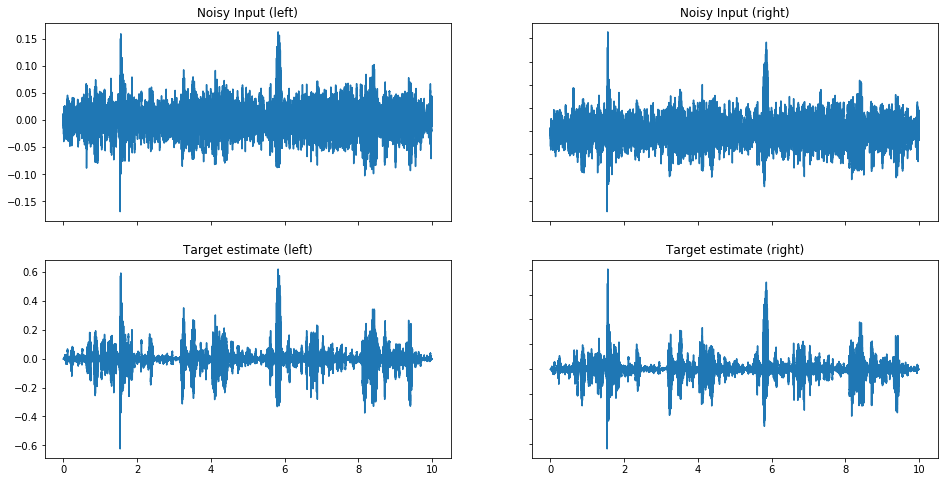

In [15]:
figure(figsize=(16, 8))

sampleTimesInSeconds = arange(numSamples) / float(sampleRate)

ax = subplot(221)
plot(sampleTimesInSeconds, stereoSamples[0])
ax.set_xticklabels([])
title('Noisy Input (left)')

ax = subplot(222)
plot(sampleTimesInSeconds, stereoSamples[1])
ax.set_xticklabels([])
ax.set_yticklabels([])
title('Noisy Input (right)')

ax = subplot(223)
plot(sampleTimesInSeconds, targetEstimateSamplesOLA[0])
title('Target estimate (left)')

ax = subplot(224)
plot(sampleTimesInSeconds, targetEstimateSamplesOLA[1])
ax.set_yticklabels([])
title('Target estimate (right)')

show()

#### Input / output audio playback:

In [16]:
targetEstimateFileName = mixtureFileNamePrefix + '_sim_realtime.wav'
wavwrite( targetEstimateSamplesOLA, targetEstimateFileName, sampleRate )

print('Noisy Mixture:')
display.display(display.Audio(mixtureFileName))

print('Target Estimate:')
display.display(display.Audio(targetEstimateFileName))

Noisy Mixture:


Target Estimate:


### Finally...
As was the case with offline speech enhancement, the trade-off between noise suppression and target fidelity may be controlled with the *targetTDOAEpsilonPercent* parameter. This parameter can be adjusted in real-time here since enhancement is performend in a frame-by-frame fashion.